# 12-Finding Protein Folding by Quantum Annealing

2012年に、Alejandroらがタンパク質折り畳み問題を量子アニーリングを用いて解きました[1]。

このチュートリアルでは、SAを用いてタンパク質折り畳み問題を解いてみました。

## 問題の概要とHydrophobic-Polar(HP)モデル、Mijazawa-Jernigan(MJ)モデル 

### 問題概要

タンパク質の立体構造をラティスフォールディングモデル[1]という単純な格子モデルとして捉え、HUBOの形式にエンコードし、最適解を求め、立体構造を決定します。特に参考論文[2]では、２次元上の構造問題として見做し、解いています。ラティスフォールディングモデルとして、タンパク質の構造を予測するために、HPモデルを使用しています。


### HPモデル 
タンパク質は数10から数100のアミノ酸配列からなるポリペプチドが折り畳まった安定した立体構造を持つが、その立体構造を決定するために、ポリペプチドの３次元立体構造をそのままの状態で扱うのは、計算量が膨大でスーパーコンピュータ等を利用しても難しい。
タンパク質分子のエネルギーを計算するには、水素結合、静電相互作用、ファンデルワールス力、疎水相互作用等の様々な力を考慮する必要があるが、疎水相互作用だけを扱った極めて単純なモデルでも多くのことが説明できる。

LauとDillは疎水性相互作用のみを考慮した格子モデルHPmodel[1]を提案した｡
このモデルは、アミノ酸は疎水性のものと親水性の2種類からなるとし､タンパク質のアミノ酸配列はHとPの配列として表現されるものである｡そして､Hモノマー同士が最近接格子にきた場合､自由エネルギーが得をするというモデルである。

参考：
- https://repository.kulib.kyoto-u.ac.jp/dspace/bitstream/2433/96792/1/KJ00004709268.pdf
- http://www.iba.t.u-tokyo.ac.jp/iba/AI/HP.pdf

<div>
    <img src="images/hp_model1.png" width="300" height="200"><br />
    図１：ラティスフォールディングモデル模式図(緑：疎水性分子(H), 青：親水性分子(P))[1]
</div>

### MJモデル
今回は単純化されたMJモデルを利用します。

## MJモデルのHUBOへの適用

用意された塩基列を特定の方向に回転させる操作をイジングモデルに対応させています。

今回使用する塩基列は、PSVKMAの配列で下記のように特定の塩基列が隣接すると安定状態になり、エネルギーが減ります。

このエネルギーの安定化を使っってコスト関数を最小化させることを考えます。また、今回塩基配列を全て一度に処理するのは難しいのでいくつかのパターンに分けます。

すでにいくつかの折り畳まれたパターンから出発して安定状態を求めます。
数が多くないので書き出すことができ、最も低いエネルギー安定状態を求めることができます。

本チュートリアルでは、実験３のschemeに絞り、取り上げて一番エネルギーの低い状態を立式から導出したいと思います。

## 　コスト関数

タンパク質の構造をラティスフォールディングモデルとして考えるにあたり、一般のコスト関数は、以下となります。

$$E_\mathrm{p} = E_\mathrm{onsite} + E_\mathrm{pw} + E_\mathrm{ext}$$

- 第１項: タンパク質の塩基列が重ならない
- 第２項: は塩基列同士の近接の相互作用のエネルギー
- 第３項: 外部からの影響

論文中の実験３については、第３項は使用しないため、コスト関数は以下となります。

$$E_\mathrm{p} = E_\mathrm{onsite} + E_\mathrm{pw}$$


## モデル

本チュートリアルでは、図　のScheme3のExperiment3を初期状態にして、考えたいと思います。塩基列は、

P-S-V-K-M-A

この順番ですが、今回はある程度折りたたまれた状態で始まります。


<div>
    <img src="images/scheme.png" width="600" height="600"><br />
     図　：　（[2]のFigure を改変）
</div>

この場合、PSKVまでは決まっていて、Mは下か左が決まっていますので、Pから順番に書いてみると、

$$010010q_10q_2q_3$$

となり、３ビットの式に還元されます。$01$は右、$00$は下、$10$は左、Mは下か左しかないので、$00$か$10$なので、$0$は決まっていて、残りの$q_1$から$q_3$をイジング問題で求めます。

<div>
    <img src="images/make_costfunction_about_protein_folding.png" width="600" height="400"><br />
    図　：　([2]のFigure を一部利用)
</div>


コスト関数は、

$$E = -1-4q_3+9q_1q_3+9q_2q_3-16q_1q_2q_3$$

## HUBOの直接解法

In [1]:
import openjij as oj

# Only SASampler can handle HUBO.
sampler = oj.SASampler()

# define polynomial
polynomial = {():-1, (3,): -4, (1,3): 9, (2,3): 9, (1,2,3): -16}

In [62]:
#SAによるシミュレーションを行う回数
num_sa = 100 

response = sampler.sample_hubo(polynomial, vartype="BINARY", updater="single spin flip", num_reads=num_sa)
energy_hubo = response.energies
energy_hubo

array([-1., -5., -5., -5., -3., -5., -5., -5., -3., -5., -5., -1., -3.,
       -1., -5.,  4., -5., -1., -5., -1., -1., -5., -5., -5., -3., -1.,
       -5., -1., -1., -5., -5., -5., -1., -1., -1., -5., -5., -5., -3.,
       -5., -1., -1., -5., -1., -5., -5., -1., -1., -5., -5., -1., -1.,
       -1., -1., -5., -5., -5., -5., -1., -5., -1., -5., -1., -3., -5.,
       -1., -5., -1., -1., -1., -1., -5., -3., -5., -3., -3., -3., -1.,
       -1., -1., -3., -1., -5., -1., -1., -1., -5., -3., -5., -1., -5.,
       -1., -3., -1., -1., -1., -5., -3., -1., -5.])

 sample_huboメソッドを用いて100回実行したところ、異なる種類の解が複数回得られることがわかります。
 解の頻度について、エネルギーのヒストグラムとして可視化してみましょう。

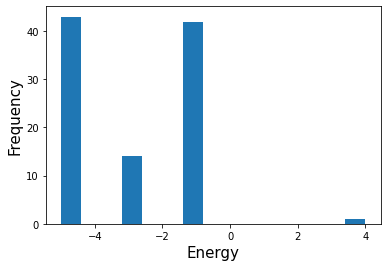

In [84]:
import matplotlib.pyplot as plt
plt.hist(energy_hubo, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが−５, −１の解が多く得られていることがわかります。

## QUBO変換による解法

In [3]:
import dimod

# Polynomial相互作用、ペナルティの大きさ、変数のタイプを指定して対応するquadraticモデルを生成する。
bqm = dimod.make_quadratic(poly=polynomial, strength=5.0, vartype="BINARY")
print('0次の項:', bqm.offset)
print('1次の項:', dict(bqm.linear))    # bqm.linearはpythonのdictに変換して表示する。
print('2次の項:', dict(bqm.quadratic)) # bqm.quadraticもpythonのdictに変換して表示する。

0次の項: -1.0
1次の項: {3: -4.0, 1: 0.0, 2: 0.0, '1*2': 15.0}
2次の項: {(1, 3): 9.0, (2, 3): 9.0, (2, 1): 5.0, ('1*2', 3): -16.0, ('1*2', 1): -10.0, ('1*2', 2): -10.0}


In [4]:
# インデックスを1始まりの整数に変換する関数
def relabel_variables_as_integers(dimod_bqm):
    mapping = {}
    variables = list(dimod_bqm.variables)
    count = 1
    for key in variables:
        mapping[key] = count
        count += 1
    linear    = {mapping[k]:v for k,v in dimod_bqm.linear.items()}
    quadratic = {(mapping[k[0]], mapping[k[1]]):v for k,v in dimod_bqm.quadratic.items()}
    return dimod.BinaryQuadraticModel(linear, quadratic, dimod_bqm.offset, dimod_bqm.vartype), mapping


bqm_relabeled, mapping = relabel_variables_as_integers(bqm) # インデックスを1始まりに変換する。

print('0次の項:', bqm_relabeled.offset)
print('1次の項:', dict(bqm_relabeled.linear))    # bqm.linearはpythonのdictに変換して表示する。
print('2次の項:', dict(bqm_relabeled.quadratic)) # bqm.quadraticもpythonのdictに変換して表示する。
print('変数の対応関係:', mapping) # Relabelした後のインデックスと元のインデックスの対応関係を表示する。

0次の項: -1.0
1次の項: {2: 0.0, 1: -4.0, 3: 0.0, 4: 15.0}
2次の項: {(1, 2): 9.0, (3, 2): 5.0, (3, 1): 9.0, (4, 2): -10.0, (4, 1): -16.0, (4, 3): -10.0}
変数の対応関係: {3: 1, 1: 2, 2: 3, '1*2': 4}


In [78]:
# dimodのbqm_relabeledはOpenJijのBinaryQuadraticModelに変換する。
bqm_oj = oj.BinaryQuadraticModel(dict(bqm_relabeled.linear), dict(bqm_relabeled.quadratic), bqm_relabeled.offset, vartype="BINARY")

# ここまでの前処理をした後に、sampleメソッドに投げることができる。
response = sampler.sample(bqm_oj, num_reads=num_sa)

QUBO変換による解法を100回実行し、解を確認してみます。
なお、QUBO変換による解法ではエネルギーの保証がないため、元のHUBOのエネルギーを得られたバイナリー配位から直接計算します。

In [91]:
# 元のHUBOの解に焼き直す。
## QUBOを変換を通した解法によるエネルギー
import numpy as np

energy_quad = np.zeros(num_sa)
for i in range(num_sa):
    hubo_configuration = {j: response.record[i][0][mapping[j]] for j in list(bqm_oj.variables)[:3]}
    energy_quad[i] = dimod.BinaryPolynomial(polynomial, "BINARY").energy(hubo_configuration)

energy_quad

array([-1.,  4., -1.,  4., -1.,  4.,  4., -1., -1., -1.,  4.,  4.,  4.,
        4.,  4., -1.,  4., -1., -1., -1., -1.,  4., -1.,  4., -1., -1.,
       -1., -1., -1.,  4., -1., -1.,  4.,  4., -1., -1., -1., -1.,  4.,
        4., -1.,  4.,  4.,  4.,  4., -1., -1.,  4., -1., -1., -1.,  4.,
       -1., -1.,  4.,  4.,  4., -1.,  4.,  4.,  4.,  4., -1., -1., -1.,
       -1., -1.,  4., -1., -1., -1.,  4.,  4., -1., -1., -1., -1., -1.,
        4.,  4.,  4.,  4.,  4., -1., -1.,  4., -1., -1.,  4.,  4., -1.,
       -1.,  4.,  4.,  4., -1.,  4.,  4., -1.,  4.])

-1と4が多く得られることがわかります。解の頻度について、エネルギーのヒストグラムとして可視化してみましょう。

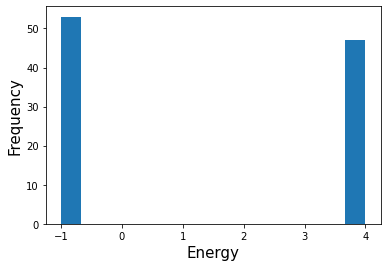

In [83]:
plt.hist(energy_quad, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが-1, 4のみの解がほぼ同じ頻度得られていることがわかります。

## 元のHUBOの最適解を確認

In [7]:
# 元のHUBOの最適解を確認する。
sampleset = dimod.ExactPolySolver().sample_hubo(H=polynomial)
print('最適解:', sampleset.first.sample)
print('対応するエネルギー:',sampleset.first.energy)

最適解: {1: 0, 2: 0, 3: 1}
対応するエネルギー: -5.0


最後に, HUBOによる直接解法とQUBO変換による解法を比較します。
SAによるシミュレーションを100回行い、各シミュレーションで得られたエネルギーを比較してみます。
結果をヒストグラムにすると次のようになります。

Text(0, 0.5, 'Frequency')

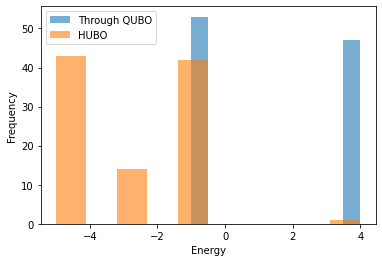

In [89]:
import matplotlib.pyplot as plt
plt.hist(energy_quad, label='Through QUBO', alpha=0.6)
plt.hist(energy_hubo, label='HUBO', alpha=0.6)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

HUBOを直接解いた方が、良いエネルギーが得られていることがわかリます。

## 引用文献

1. Dill KA (March 1985). "Theory for the folding and stability of globular proteins". Biochemistry. 24 (6)
2. Alejandro Perdomo-Ortiz, et.al "Finding low-energy conformations of lattice protein models by quantum annealing". Scientific Reports volume 2, Article number: 571 (2012)